### Energy-based Latent Aligner for Incremental Learning | [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JosephKJ/ELI/blob/main/ELI_512.ipynb)

#### CVPR 2022

This notebook contains code to replicate the MNIST experiment described in Section 3.3. The size of the latent dimention is **512**. The key logic of our proposed methodology is encapsulated inside `EBMAligner` class.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:
# some initial imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import manifold
from time import time
from matplotlib.ticker import NullFormatter
import copy

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [3]:
seed = 120
np.random.seed(seed=seed)
torch.manual_seed(seed)

In [4]:
# Setting up Device.
use_cuda = True
use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [5]:
# Getting MNIST data
!git clone https://github.com/ContinualAI/colab.git continualai/colab
from continualai.colab.scripts import mnist
mnist.init()

x_train, t_train, x_test, t_test = mnist.load()

print(f'Size of training data is: {t_train.shape[0]}, size of test data: {t_test.shape[0]}')

fatal: destination path 'continualai/colab' already exists and is not an empty directory.
Files already downloaded!
Size of training data is: 60000, size of test data: 10000


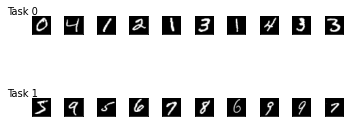

In [6]:
# Creating two tasks
task_classes_arr = [(0, 1, 2, 3, 4), (5, 6, 7, 8, 9)]
tasks_num = len(task_classes_arr) # 5

task_data = []
for i, task_classes in enumerate(task_classes_arr):
  train_mask = np.isin(t_train, task_classes)
  test_mask = np.isin(t_test, task_classes)
  x_train_task, t_train_task = x_train[train_mask], t_train[train_mask] - task_classes[0]
  x_test_task, t_test_task = x_test[test_mask], t_test[test_mask] - task_classes[0]
  task_data.append((x_train_task, t_train_task, x_test_task, t_test_task))

# Display tasks
def plot_task(axs, data, samples_num):
  for sample in range(samples_num):
    axs[sample].imshow(data[sample][0], cmap="gray")
    axs[sample].xaxis.set_ticks([])
    axs[sample].yaxis.set_ticks([])

n_tasks, samples = 2, 10
_, axs = plt.subplots(n_tasks, samples, figsize=(5, 3))
for task in range(n_tasks):
  axs[task, 0].set_ylabel(f'Task {task}', rotation=0)
  axs[task, 0].yaxis.set_label_coords(-0.5,1)
  plot_task(axs[task], task_data[task][0], samples)
plt.tight_layout()

In [7]:
class Base(nn.Module):
  def __init__(self, hsize=32):
    super(Base, self).__init__()
    self.l1 = nn.Linear(784, hsize)
    
  def forward(self, x, return_z_also=False):
    x = x.view(x.size(0), -1)
    z = self.l1(x)
    if return_z_also:
        return z
    else:
        return z

class Head(nn.Module):
  def __init__(self, fe, hsize=32):
    super(Head, self).__init__()
    self.fe = fe
    self.l2 = nn.Linear(hsize, 5)

  def clf(self, z):
    x = self.l2(F.relu(z))
    return x

  def forward(self, x, return_z_also=False):
    z = self.fe.forward(x)
    x = self.clf(z)
    if return_z_also:
        return x, z
    else:
        return x, z

In [8]:
class Metrics:
    def __init__(self):
        self.val = 0
        self.sum = 0
        self.count = 0
        self.avg = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val*n
        self.count += n
        self.avg = self.sum / self.count
        
def compute_accuracy(output, target, topk=(1,)):
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    result = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        result.append(correct_k.mul_(100.0 / batch_size))
    return result

def train(model, device, train_loader, optimizer, epochs=10, log_training=False):
    for epoch in range(epochs):
      model.train()
      
      for x, y in train_loader:
        x, y = x.to(device), y.to(device).long()
        
        optimizer.zero_grad()

        output, _ = model(x)
        loss = F.cross_entropy(output, y)
        loss.backward()
        optimizer.step()
        if log_training:
          print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    accuracy_metric = Metrics()

    for x, y in test_loader:
      with torch.no_grad():
        x, y = x.to(device), y.to(device).long()
        output, _ = model(x)
        test_loss += F.cross_entropy(output, y).item() # sum up batch loss

        accuracy = compute_accuracy(output, y)[0].item()
        accuracy_metric.update(accuracy)

    test_loss /= len(test_loader)
    return test_loss, accuracy_metric.avg

In [9]:
def plot_tsne(X, label, name='latents'):
    n_components = 2
    perplexity = 30

    tsne = manifold.TSNE(n_components=n_components, init='random',
                          random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(X)

    sns.scatterplot(x=Y[:, 0], y=Y[:, 1], hue=label, legend='full',  palette='jet')
    plt.xlim([-100, 100])
    plt.ylim([-100, 100])
    plt.axis('off')
    plt.legend(loc=8, fontsize=12, ncol=5)
    plt.savefig('{}_tsne.png'.format(name), bbox_inches='tight',pad_inches = 0)
    plt.show()

def visualize_latents(model, device, test_loader, name='latents'):
    model.eval()
    latents = []
    labels = []
    for x, y in test_loader:
      with torch.no_grad():
        x, y = x.to(device), y.to(device).int()
        _, z = model(x)
        latents.extend(z.cpu().numpy())
        labels.extend(y.cpu().numpy())

    plot_tsne(np.array(latents), np.array(labels), name)

Training on Task 1
Testing on Task 1: accuracy -> 99.54268292682927


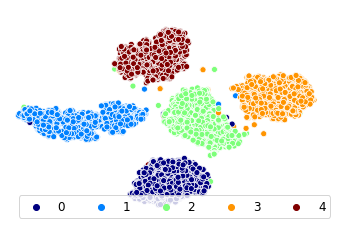

In [10]:
z_size = 512

base_model = Base(hsize=z_size).to(device)
model_t1 = Head(base_model, hsize=z_size).to(device)
model_t2 = Head(base_model, hsize=z_size).to(device)

optimizer = optim.SGD(model_t1.parameters(), lr=0.1, momentum=0.9)
x_train_1, t_train_1, x_test_1, t_test_1 = task_data[0]
x_train_2, t_train_2, x_test_2, t_test_2 = task_data[1]

t1_train_ds = TensorDataset(torch.Tensor(x_train_1), torch.Tensor(t_train_1))
t1_test_ds = TensorDataset(torch.Tensor(x_test_1), torch.Tensor(t_test_1))
t2_train_ds = TensorDataset(torch.Tensor(x_train_2), torch.Tensor(t_train_2))
t2_test_ds = TensorDataset(torch.Tensor(x_test_2), torch.Tensor(t_test_2))

batch_size = 128
t1_train_loader = DataLoader(t1_train_ds, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
t1_test_loader = DataLoader(t1_test_ds, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=False)
t2_train_loader = DataLoader(t2_train_ds, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
t2_test_loader = DataLoader(t2_test_ds, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=False)

print('Training on Task 1')
train(model_t1, device, t1_train_loader, optimizer, epochs=10)

loss, acc = test(model_t1, device, t1_test_loader)
print(f'Testing on Task 1: accuracy -> {acc}')

model_t1_backup = copy.deepcopy(model_t1)

visualize_latents(model_t1, device, t1_test_loader, name='after_task1')

Training on Task 2
Testing on Task 1 using model_t2: loss -> 2.8120585331102697, acc -> 38.06462608895651
Testing on Task 2 using model_t2: loss -> 0.10141554715013817, acc -> 96.83190797504626
Testing on Task 1 using model_t1: loss -> 0.7252096897218285, acc -> 89.14373388523009
Testing on Task 2 using model_t1: loss -> 15.449862429970189, acc -> 21.474671062670257
Testing on Task 1 using model_t1_backup: loss -> 0.012032548019594354, acc -> 99.54268292682927
Testing on Task 2 using model_t1_backup: loss -> 5.0559755689219426, acc -> 38.83601971676475


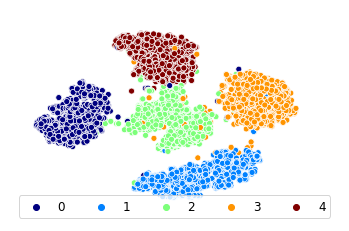

In [11]:
print('Training on Task 2')
train(model_t2, device, t2_train_loader, optimizer, epochs=10)

loss, acc = test(model_t2, device, t1_test_loader)
print(f'Testing on Task 1 using model_t2: loss -> {loss}, acc -> {acc}')
loss, acc = test(model_t2, device, t2_test_loader)
print(f'Testing on Task 2 using model_t2: loss -> {loss}, acc -> {acc}')

loss, acc = test(model_t1, device, t1_test_loader)
print(f'Testing on Task 1 using model_t1: loss -> {loss}, acc -> {acc}')
loss, acc = test(model_t1, device, t2_test_loader)
print(f'Testing on Task 2 using model_t1: loss -> {loss}, acc -> {acc}')

loss, acc = test(model_t1_backup, device, t1_test_loader)
print(f'Testing on Task 1 using model_t1_backup: loss -> {loss}, acc -> {acc}')
loss, acc = test(model_t1_backup, device, t2_test_loader)
print(f'Testing on Task 2 using model_t1_backup: loss -> {loss}, acc -> {acc}')

visualize_latents(model_t2, device, t1_test_loader, name='after_task2')

In [12]:
class EBMAligner:
    """Manages the lifecycle of the proposed Energy Based Latent Alignment.
    """
    def __init__(self):
        self.enabled = False

        # Configs of the EBM model
        self.ebm_latent_dim = 512
        self.ebm_n_layers = 1
        self.ebm_n_hidden_layers = 64
        self.ebm_ema = None

        # EBM Learning configs
        self.max_iter = 8500
        self.ebm_lr = 0.0001
        self.n_langevin_steps = 30
        self.langevin_lr = 0.1
        self.ema_decay = 0.89

        # EBM Loss config
        self.alpha = 1.0

    def ema(self, model1, model2, decay=0.999):
        par1 = dict(model1.named_parameters())
        par2 = dict(model2.named_parameters())
        for k in par1.keys():
            par1[k].data.mul_(decay).add_(par2[k].data, alpha=1 - decay)

    def requires_grad(self, model, flag=True):
        for p in model.parameters():
            p.requires_grad = flag

    def sampler(self, ebm_model, x, langevin_steps=30, lr=0.1):
        """The langevin sampler to sample from the ebm_model

        :param ebm_model: The source EBM model
        :param x: The data which is updated to minimize energy from EBM
        :param langevin_steps: The number of langevin steps
        :param lr: The langevin learning rate
        :return: Samples from EBM
        """
        x = x.clone().detach()
        x.requires_grad_(True)
        sgd = torch.optim.SGD([x], lr=lr)

        for k in range(langevin_steps):
            ebm_model.zero_grad()
            sgd.zero_grad()
            energy = ebm_model(x).sum()

            (-energy).backward()
            sgd.step()

        return x.clone().detach()

    def learn_ebm(self, prev_model, current_model, current_task_data, validation_data=None):
        """Learn the EBM.

        current_task_data + prev_model acts as in-distribution data, and
        current_task_data + current_model acts as out-of-distribution data.
        This is used for learning the energy manifold.

        :param prev_model: Model trained till previous task.
        :param current_model: Model trained on current task.
        :param current_task_data: Datapoints from the current incremental task.
        :param validation_data: OPTIONAL, if passed, used for evaluation.
        :return: None.
        """
        ebm = EBM(latent_dim=self.ebm_latent_dim, n_layer=self.ebm_n_layers,
                       n_hidden=self.ebm_n_hidden_layers).cuda()
        if self.ebm_ema is None:
            self.ebm_ema = EBM(latent_dim=self.ebm_latent_dim, n_layer=self.ebm_n_layers,
                               n_hidden=self.ebm_n_hidden_layers).cuda()
            # Initialize the exponential moving average of the EBM.
            self.ema(self.ebm_ema, ebm, decay=0.)

        ebm_optimizer = torch.optim.RMSprop(ebm.parameters(), lr=self.ebm_lr)

        iterations = 0
        prev_model.eval()
        current_model.eval()
        data_iter = iter(current_task_data)

        print('Starting to learn the EBM')
        while iterations < self.max_iter:
            ebm.zero_grad()
            ebm_optimizer.zero_grad()

            try:
                inputs, _ = next(data_iter)
            except (OSError, StopIteration):
                data_iter = iter(current_task_data)
                inputs, _ = next(data_iter)

            inputs = inputs.cuda()
            _, prev_z = prev_model(inputs, return_z_also=True)
            _, current_z = current_model(inputs, return_z_also=True)

            self.requires_grad(ebm, False)
            sampled_z = self.sampler(ebm, current_z.clone().detach(), langevin_steps=self.n_langevin_steps, lr=self.langevin_lr)
            self.requires_grad(ebm, True)

            indistribution_energy = ebm(prev_z)
            oodistribution_energy = ebm(sampled_z)

            loss = -(indistribution_energy - oodistribution_energy).mean()

            loss.backward()
            ebm_optimizer.step()
            self.ema(self.ebm_ema, ebm, decay=self.ema_decay)

            if iterations == 0 or iterations % 1000 == 0:
                if validation_data is not None:
                    accuracy = self.evaluate(prev_model, current_model, validation_data)
                    print("Iteration: {:5d}, accuracy: {:5.2f}".format(iterations, accuracy))
                else:
                    print("Iter: {:5d}".format(iterations))

            iterations += 1

        self.enabled = True

    def evaluate(self, previous_model, current_model, validation_data):
        previous_model.eval()
        current_model.eval()
        accuracy_metric = Metrics()

        for inputs, labels in validation_data:
            inputs = inputs.cuda()
            labels = labels.cuda()
            _, current_z = current_model(inputs, return_z_also=True)
            aligned_z = self.align_latents(current_z)

            output = previous_model.clf(aligned_z)
            accuracy = self.compute_accuracy(output, labels)[0].item()
            accuracy_metric.update(accuracy)

        return accuracy_metric.avg

    def compute_accuracy(self, output, target, topk=(1,)):
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        result = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0)
            result.append(correct_k.mul_(100.0 / batch_size))
        return result

    def align_latents(self, z):
        self.requires_grad(self.ebm_ema, False)
        aligned_z = self.sampler(self.ebm_ema, z.clone().detach(), langevin_steps=self.n_langevin_steps, lr=self.langevin_lr)
        self.requires_grad(self.ebm_ema, True)
        return aligned_z


class EBM(nn.Module):
    """Defining the Energy Based Model.
    """
    def __init__(self, latent_dim=32, n_layer=1, n_hidden=64):
        super().__init__()

        mlp = nn.ModuleList()
        if n_layer == 0:
            mlp.append(nn.Linear(latent_dim, 1))
        else:
            mlp.append(nn.Linear(latent_dim, n_hidden))

            for _ in range(n_layer-1):
                mlp.append(nn.LeakyReLU(0.2))
                mlp.append(nn.Linear(n_hidden, n_hidden))

            mlp.append(nn.LeakyReLU(0.2))
            mlp.append(nn.Linear(n_hidden, 1))

        self.mlp = nn.Sequential(*mlp)

    def forward(self, x):
        return self.mlp(x)


class Metrics:
    def __init__(self):
        self.val = 0
        self.sum = 0
        self.count = 0
        self.avg = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val*n
        self.count += n
        self.avg = self.sum / self.count

In [13]:
aligner = EBMAligner()
aligner.learn_ebm(model_t1_backup, model_t2, t2_train_loader, t1_test_loader)

Starting to learn the EBM
Iteration:     0, accuracy: 89.19
Iteration:  1000, accuracy: 90.99
Iteration:  2000, accuracy: 96.97
Iteration:  3000, accuracy: 98.46
Iteration:  4000, accuracy: 98.65
Iteration:  5000, accuracy: 98.76
Iteration:  6000, accuracy: 98.97
Iteration:  7000, accuracy: 99.05
Iteration:  8000, accuracy: 99.05


Accuracy from un-modified latents : 89.14373388523009
Accuracy from aligned latents (using ELI): 99.04725609756098


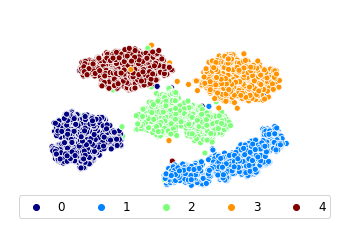

In [14]:
def align(model, aligner, device, data_loader):
  model.eval()
  model_t1.eval()
  latents = []
  labels = []
  accuracy_metric = Metrics()
  accuracy_metric_adap = Metrics()
    
  for x, y in data_loader:
    x, y = x.to(device), y.to(device).long()
    _, z = model(x)

    output = model_t1.clf(z)
    accuracy = compute_accuracy(output, y)[0].item()
    accuracy_metric.update(accuracy)

    z_samples = aligner.align_latents(z.clone().detach())

    output = model_t1.clf(z_samples)
    accuracy = compute_accuracy(output, y)[0].item()
    accuracy_metric_adap.update(accuracy)

    latents.extend(z_samples.cpu().numpy())
    labels.extend(y.cpu().numpy())

  print('Accuracy from un-modified latents : {}'.format(accuracy_metric.avg))
  print('Accuracy from aligned latents (using ELI): {}'.format(accuracy_metric_adap.avg))

  plot_tsne(np.array(latents), np.array(labels), name='after_adaptation')

align(model_t2, aligner, device, t1_test_loader)